In [1]:
# uncomment these two lines if using a gpu for a speedup
#! nvidia-smi
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from desc import set_device

set_device("gpu")

In [2]:
from desc import equilibrium

DESC version 0.12.2+396.gbe6346c02.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory


In [3]:
# imports

import numpy as np
from desc.coils import CoilSet, FourierPlanarCoil
import desc.examples
from desc.equilibrium import Equilibrium
from desc.plotting import plot_surfaces, plot_2d, plot_3d, plot_coils
from desc.grid import LinearGrid, ConcentricGrid
from desc.coils import MixedCoilSet
from desc.objectives import (
    ObjectiveFunction,
    # coil
    CoilCurvature,
    CoilLength,
    CoilTorsion,
    CoilSetMinDistance,
    PlasmaCoilSetMinDistance,
    QuadraticFlux,
    ToroidalFlux,
    FixCoilCurrent,
    FixSumCoilCurrent,
    FixParameters,
    # plasma
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixCurrent,
    FixIota,
    FixPsi,
    AspectRatio,
    ForceBalance,
    QuasisymmetryBoozer,
    QuasisymmetryTwoTerm,
    QuasisymmetryTripleProduct,
    VacuumBoundaryError,
)
from desc.continuation import solve_continuation_automatic
from desc.optimize import Optimizer
from desc.magnetic_fields import field_line_integrate
from desc.integrals import compute_B_plasma
import time
import plotly.express as px
import plotly.io as pio
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface


# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
pio.renderers.default = "png"

In [4]:
# plotting
from desc.plotting import (
    plot_grid,
    plot_boozer_modes,
    plot_boozer_surface,
    plot_qs_error,
    plot_boundaries,
    plot_boundary,
)

In [32]:
##################################
# Generating initial equilibrium #
##################################

eq_init = desc.io.load("./qs_initial_guess_vac.h5")
orig_eq = eq_init.copy()
# eq_init.current = PowerSeriesProfile()
# eq_init.iota = None
# eq_init.pressure = PowerSeriesProfile()

In [33]:
##############################
# Generating initial coilset #
##############################

minor_radius = eq_init.compute("a")["a"]
offset = 0.3
num_coils = 4  # coils per half field period

zeta = np.linspace(0, np.pi / eq_init.NFP, num_coils, endpoint=False) + np.pi / (
    2 * eq_init.NFP * num_coils
)
grid = LinearGrid(rho=[0.0], M=0, zeta=zeta, NFP=eq_init.NFP)
data = eq_init.axis.compute(["x", "x_s"], grid=grid, basis="rpz")

centers = data["x"]  # center coils on axis position
normals = data["x_s"]  # make normal to coil align with tangent along axis

unique_coils = []
for k in range(num_coils):
    coil = FourierPlanarCoil(
        current=1e6,
        center=centers[k, :],
        normal=normals[k, :],
        r_n=minor_radius + offset,
        basis="rpz",  # we are giving the center and normal in cylindrical coordinates
    ).to_FourierXYZ(
        N=5
    )  # fit with 10 fourier coefficients per coil
    unique_coils.append(coil)

# We package these coils together into a CoilSet, which has efficient methods for calculating
# the total field while accounting for field period and stellarator symmetry
# Note that `CoilSet` requires all the member coils to have the same parameterization and resolution.
# if we wanted to use coils of different types or resolutions, we can use a `MixedCoilSet` (see the next section below)
coilset = CoilSet(unique_coils, NFP=eq_init.NFP, sym=eq_init.sym)

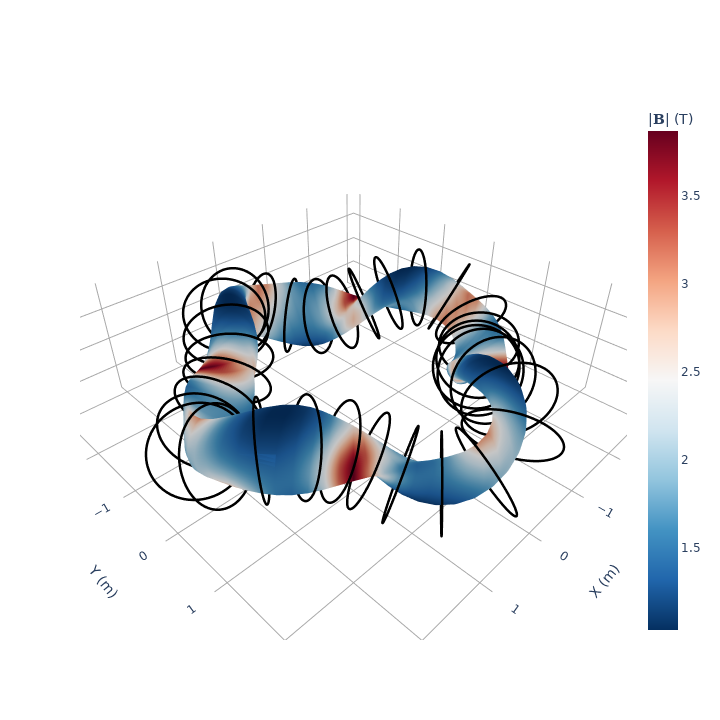

In [34]:
fig = plot_3d(eq_init, "|B|", grid=LinearGrid(M=40, N=40, endpoint=True))
plot_coils(coilset, fig=fig)

In [35]:
coilset.coils

[FourierXYZCoil at 0x149829a64810 (name=, current=1000000.0),
 FourierXYZCoil at 0x149811e3a290 (name=, current=1000000.0),
 FourierXYZCoil at 0x14986adcda50 (name=, current=1000000.0),
 FourierXYZCoil at 0x14986adee0d0 (name=, current=1000000.0)]

In [36]:
# coils need to obey a certain current due to ampere's law, initialize with
# the correct currents
from scipy.constants import mu_0

tot_req_current = 2 * np.pi * eq_init.compute("G")["G"][-1] / mu_0 / coilset.NFP / 2

# to use this constraint to satisfy Ampere's law for the targeted equilibrium,
obj_currs = FixSumCoilCurrent(coilset, target=tot_req_current)

In [37]:
coilset.compute_magnetic_field([2, 0, 0])

Array([[-2.38697950e-15,  4.69787586e+00,  2.05103798e+00]], dtype=float64)

In [38]:
data = eq_init.compute(["R", "phi", "Z", "B"])
print(data["B"][0])
coilset.compute_magnetic_field([data["R"][0], data["phi"][0], data["Z"][0]])

[-4.38892379e-19  2.10734925e+00  1.12050923e+00]


Array([[-5.55111512e-16,  2.08822147e+00,  9.04526529e-01]], dtype=float64)

In [39]:
grid_vol = ConcentricGrid(
    L=eq_init.L_grid,
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
)

grid_lcfs = LinearGrid(
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
    rho=np.array(1.0),
)

coil_grid = LinearGrid(N=75)
plasma_grid = LinearGrid(M=30, N=30, NFP=eq_init.NFP, sym=eq_init.sym)

coil_indices_to_fix_current = [False for c in coilset]
coil_indices_to_fix_current[0] = True
constraints = (
    ForceBalance(eq=eq_init),
    obj_currs,
    FixPressure(
        eq=eq_init
    ),  # fix pressure profile (i.e. dont let it change during optimization)
    FixPsi(
        eq=eq_init
    ),  # fix total toroidal magnetic flux (i.e. dont let it change during optimization)
    FixCurrent(eq=eq_init),  # Fix current (i.e. dont let it change during optimization)
)

obj = ObjectiveFunction(
    (
        VacuumBoundaryError(
            eq=eq_init,  # this objective is both quadratic flux AND boundary magnetic pressure, i.e.
            # the objectives for free bdry in vacuum (zero quad flux and continuous B^2 across bdry)
            field=coilset,
            field_grid=coil_grid,
            grid=plasma_grid,
            weight=1e2,
        ),
        QuasisymmetryTwoTerm(
            eq=eq_init, helicity=(1, eq_init.NFP), grid=grid_lcfs, weight=10
        ),
        CoilSetMinDistance(
            coilset,
            # in normalized units, want coil-coil distance to be at least 10% of minor radius
            bounds=(0.1, np.inf),
            normalize_target=False,  # we're already giving bounds in normalized units
            grid=coil_grid,
            weight=200,
        ),
        PlasmaCoilSetMinDistance(
            eq_init,
            coilset,
            # in normalized units, want plasma-coil distance to be at least 25% of minor radius
            bounds=(0.25, np.inf),
            normalize_target=False,  # we're already giving bounds in normalized units
            plasma_grid=plasma_grid,
            coil_grid=coil_grid,
            eq_fixed=False,  # Fix the equilibrium. For single stage optimization, this would be False
            weight=200,
        ),
        CoilCurvature(
            coilset,
            # this uses signed curvature, depending on whether it curves towards
            # or away from the centroid of the curve, with a circle having positive curvature.
            # We give the bounds normalized units, curvature of approx 1 means circular,
            # so we allow them to be a bit more strongly shaped
            bounds=(-1, 2),
            normalize_target=False,  # we're giving bounds in normalized units
            grid=coil_grid,
            weight=75,
        ),
        CoilLength(
            coilset,
            bounds=(0, 2 * np.pi * (minor_radius + offset)),
            normalize_target=True,  # target length is in meters, not normalized
            grid=coil_grid,
            weight=100,
        ),
    )
)


# def compute_average_normalized_field(field, eq_init, vacuum=False):
#     grid = LinearGrid(M=80, N=80, NFP=eq_init.NFP)
#     Bn, surf_coords = field.compute_Bnormal(eq_init, eval_grid=grid)
#     normalizing_field_vec = field.compute_magnetic_field(surf_coords)
#     if not vacuum:
#         # add plasma field to the normalizing field
#         normalizing_field_vec += compute_B_plasma(eq_init, eval_grid=grid)
#     normalizing_field = np.mean(np.linalg.norm(normalizing_field_vec, axis=1))
#     return np.mean(np.abs(Bn)) / normalizing_field

In [40]:
optimizer = Optimizer("proximal-lsq-exact")


(
    eq_qs_T,
    optimized_coilset,
), result_T = optimizer.optimize(
    (eq_init, coilset),
    objective=obj,
    constraints=constraints,
    ftol=1e-4,  # stopping tolerance on the function value
    xtol=1e-8,  # stopping tolerance on the step size
    gtol=1e-8,  # stopping tolerance on the gradient
    maxiter=150,  # maximum number of iterations
    options={
        "perturb_options": {"order": 2, "verbose": 0},  # use 2nd-order perturbations
        "solve_options": {
            "ftol": 1e-2,
            "xtol": 1e-6,
            "gtol": 1e-6,
            "verbose": 0,
        },  # for equilibrium subproblem
    },
    copy=True,  # copy=True to make a copy of the optimized result and dont touch the orignals
    verbose=3,
)

Building objective: Vacuum boundary error
Precomputing transforms
Timer: Precomputing transforms = 30.3 ms
Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 56.5 ms
Building objective: coil-coil minimum distance
Building objective: plasma-coil minimum distance
Building objective: coil curvature
Precomputing transforms
Timer: Precomputing transforms = 4.82 ms
Building objective: coil length
Precomputing transforms
Timer: Precomputing transforms = 3.09 ms
Timer: Objective build = 457 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 65.2 ms
Timer: Objective build = 76.7 ms
Timer: Proximal projection build = 1.38 sec
Building objective: summed coil current
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Timer: Objective build = 75.3 ms
Timer: Linear constraint projection build = 1.43 sec
Number of parameters: 336
Number of objectives: 4743
Timer: Initializing the o

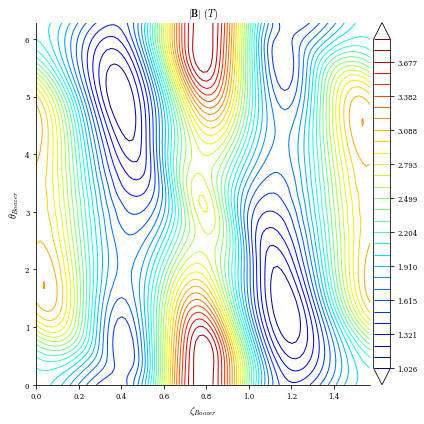

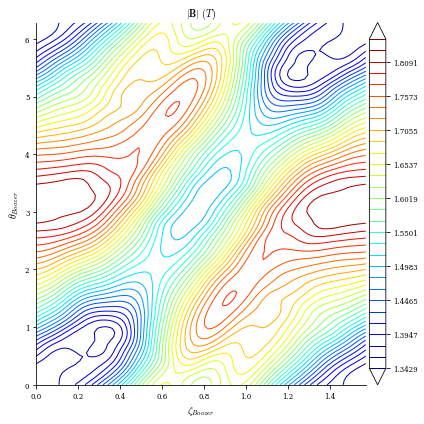

In [41]:
plot_boozer_surface(eq_init)
plot_boozer_surface(eq_qs_T);  # |B| contours at rho=1 surface

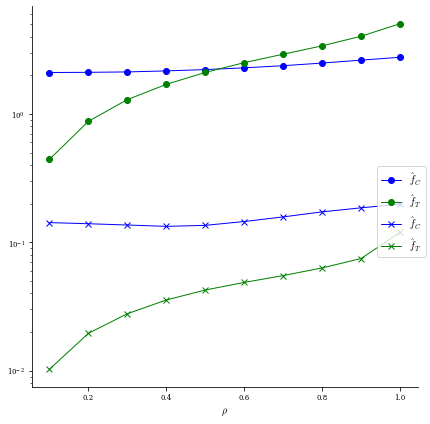

In [42]:
# compare f_T & f_C before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fB=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_T, helicity=(1, eq_qs_T.NFP), fB=False, ax=ax, marker=["x", "x"], rho=10
);

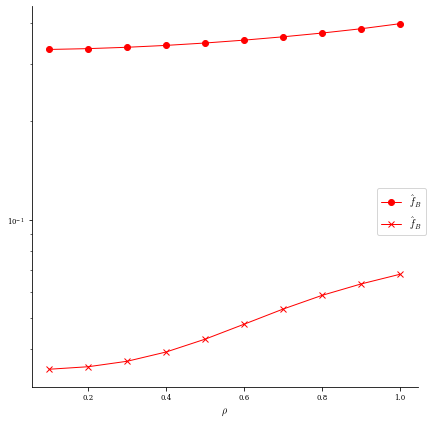

In [43]:
# compare f_B before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fT=False, fC=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_T, helicity=(1, eq_qs_T.NFP), fT=False, fC=False, ax=ax, marker=["x"], rho=10
);

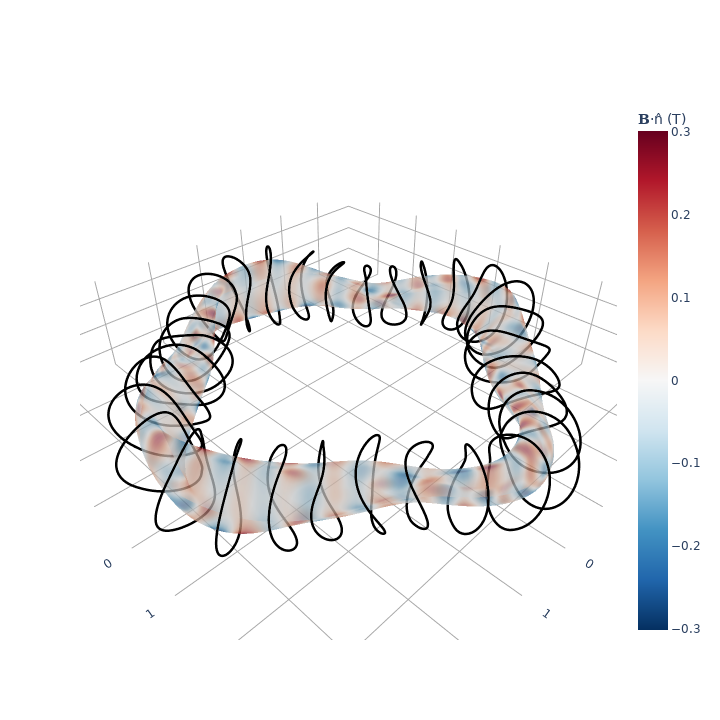

In [44]:
fig = plot_3d(
    eq_qs_T.surface, "B*n", field=optimized_coilset, alpha=0.5
)  # pass in surface so the Bplasma is not computed, as it is vacuum
plot_coils(optimized_coilset, fig=fig)
# plot_coils(coilset,fig=fig,color="red")

In [46]:
eq_init = eq_qs_T.copy()
eq1 = eq_qs_T.copy()
coils1 = optimized_coilset.copy()
# eq_init = eq_qs_T.copy()
coilset = optimized_coilset.copy()

In [47]:
# coils need to obey a certain current due to ampere's law, initialize with
# the correct currents
from scipy.constants import mu_0

tot_req_current = (
    2
    * np.pi
    * eq_init.compute(
        "G",
        grid=LinearGrid(rho=1.0, M=eq_init.M_grid, N=eq_init.N_grid, NFP=eq_init.NFP),
    )["G"][-1]
    / mu_0
    / coilset.NFP
    / 2
)

# to use this constraint to satisfy Ampere's law for the targeted equilibrium,
obj_currs = FixSumCoilCurrent(coilset, target=tot_req_current)

In [48]:
grid_vol = ConcentricGrid(
    L=eq_init.L_grid,
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
)

grid_lcfs = LinearGrid(
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
    rho=np.array(1.0),
)

coil_grid = LinearGrid(N=75)
plasma_grid = LinearGrid(M=30, N=30, NFP=eq_init.NFP, sym=eq_init.sym)

coil_indices_to_fix_current = [False for c in coilset]
coil_indices_to_fix_current[0] = True
constraints = (
    ForceBalance(eq=eq_init),
    obj_currs,
    FixPressure(
        eq=eq_init
    ),  # fix pressure profile (i.e. dont let it change during optimization)
    FixPsi(
        eq=eq_init
    ),  # fix total toroidal magnetic flux (i.e. dont let it change during optimization)
    FixCurrent(eq=eq_init),  # Fix current (i.e. dont let it change during optimization)
)

obj = ObjectiveFunction(
    (
        VacuumBoundaryError(
            eq=eq_init,  # this objective is both quadratic flux AND boundary magnetic pressure, i.e.
            # the objectives for free bdry in vacuum (zero quad flux and continuous B^2 across bdry)
            field=coilset,
            field_grid=coil_grid,
            grid=plasma_grid,
            weight=1.1e2,
        ),
        QuasisymmetryTwoTerm(
            eq=eq_init, helicity=(1, eq_init.NFP), grid=grid_lcfs, weight=10
        ),
        CoilSetMinDistance(
            coilset,
            # in normalized units, want coil-coil distance to be at least 10% of minor radius
            bounds=(0.1, np.inf),
            normalize_target=False,  # we're already giving bounds in normalized units
            grid=coil_grid,
            weight=200,
        ),
        PlasmaCoilSetMinDistance(
            eq_init,
            coilset,
            # in normalized units, want plasma-coil distance to be at least 25% of minor radius
            bounds=(0.25, np.inf),
            normalize_target=False,  # we're already giving bounds in normalized units
            plasma_grid=plasma_grid,
            coil_grid=coil_grid,
            eq_fixed=False,  # Fix the equilibrium. For single stage optimization, this would be False
            weight=200,
        ),
        CoilCurvature(
            coilset,
            # this uses signed curvature, depending on whether it curves towards
            # or away from the centroid of the curve, with a circle having positive curvature.
            # We give the bounds normalized units, curvature of approx 1 means circular,
            # so we allow them to be a bit more strongly shaped
            bounds=(-1, 2),
            normalize_target=False,  # we're giving bounds in normalized units
            grid=coil_grid,
            weight=65,
        ),
        CoilLength(
            coilset,
            bounds=(0, 2 * np.pi * (minor_radius + offset)),
            normalize_target=True,  # target length is in meters, not normalized
            grid=coil_grid,
            weight=100,
        ),
    )
)

In [49]:
optimizer = Optimizer("proximal-lsq-exact")


(
    eq_qs_T,
    optimized_coilset,
), result_T = optimizer.optimize(
    (eq_init, coilset),
    objective=obj,
    constraints=constraints,
    ftol=1e-4,  # stopping tolerance on the function value
    xtol=1e-8,  # stopping tolerance on the step size
    gtol=1e-8,  # stopping tolerance on the gradient
    maxiter=50,  # maximum number of iterations
    options={
        "perturb_options": {"order": 2, "verbose": 0},  # use 2nd-order perturbations
        "solve_options": {
            "ftol": 1e-2,
            "xtol": 1e-6,
            "gtol": 1e-6,
            "verbose": 0,
        },  # for equilibrium subproblem
    },
    copy=True,  # copy=True to make a copy of the optimized result and dont touch the orignals
    verbose=3,
)

Building objective: Vacuum boundary error
Precomputing transforms
Timer: Precomputing transforms = 30.0 ms
Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 58.6 ms
Building objective: coil-coil minimum distance
Building objective: plasma-coil minimum distance
Building objective: coil curvature
Precomputing transforms
Timer: Precomputing transforms = 4.33 ms
Building objective: coil length
Precomputing transforms
Timer: Precomputing transforms = 3.55 ms
Timer: Objective build = 461 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 65.4 ms
Timer: Objective build = 77.5 ms
Timer: Proximal projection build = 1.03 sec
Building objective: summed coil current
Building objective: fixed pressure
Building objective: fixed Psi
Building objective: fixed current
Timer: Objective build = 82.9 ms
Timer: Linear constraint projection build = 491 ms
Number of parameters: 336
Number of objectives: 4743
Timer: Initializing the opt

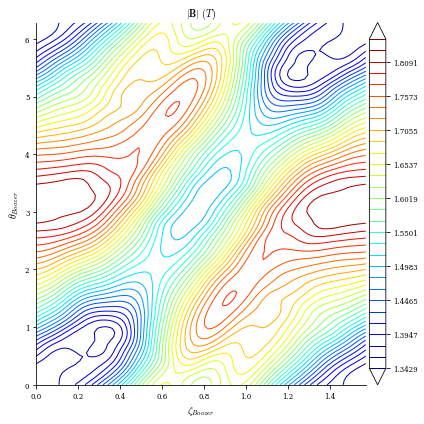

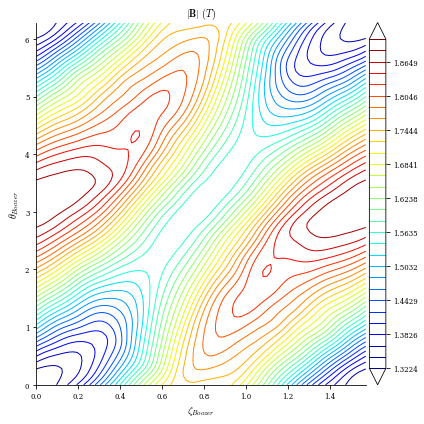

In [50]:
plot_boozer_surface(eq_init)
plot_boozer_surface(eq_qs_T);  # |B| contours at rho=1 surface

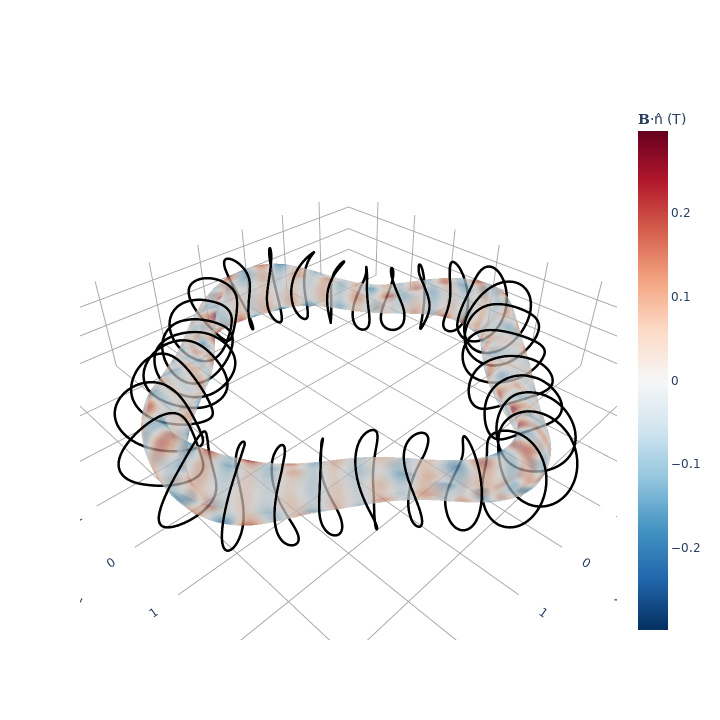

In [51]:
fig = plot_3d(
    eq_qs_T.surface, "B*n", field=optimized_coilset, alpha=0.5
)  # pass in surface so the Bplasma is not computed, as it is vacuum
plot_coils(optimized_coilset, fig=fig)
# plot_coils(coilset,fig=fig,color="red")

In [52]:
def plot_field_lines(field, eq_init):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
    r0 = eq_init.compute("R", grid=grid_trace)["R"]
    z0 = eq_init.compute("Z", grid=grid_trace)["Z"]
    fig, ax = desc.plotting.plot_surfaces(eq_init)
    fig, ax = desc.plotting.poincare_plot(
        field,
        r0,
        z0,
        NFP=eq_init.NFP,
        ax=ax,
        color="k",
        size=1,
    )
    return fig, ax

In [ ]:
# plot_field_lines(optimized_coilset, eq_qs_T)